# Word2Vec on Arabic
Implement Word2Vec in pytorch to compute vector representations of Arabic words. 
This example uses Arabic book reviews dataset - [link](http://www.mohamedaly.info/datasets/labr)

The implementation is based on **Skip-gram Model** as described in the following [paper](https://arxiv.org/abs/1301.3781):

    Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean, Efficient Estimation of Word Representations in Vector Space, 2013


https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/dzlab/deepprojects/blob/master/nlp/word2vec_arabic.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/dzlab/deepprojects/blob/master/nlp/word2vec_arabic.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Imports

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import re
import collections
import pdb

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [54]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [5]:
torch.manual_seed(1)

In [6]:
!nvidia-smi

Sat Mar  2 16:41:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Data

In [0]:
PATH = Path('.')

In [8]:
!curl -O https://raw.githubusercontent.com/mohamedadaly/LABR/master/data/reviews.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38.0M  100 38.0M    0     0  38.8M      0 --:--:-- --:--:-- --:--:-- 38.8M


In [0]:
columns = ['rating', 'review id', 'user id', 'book id', 'review']
df = pd.read_csv(PATH/'reviews.tsv', delimiter='\t', names=columns)

In [9]:
df.head()

,rating,review id,user id,book id,review
0,4,338670838,7878381,13431841,"""عزازيل الذي صنعناه ،الكامن في أنفسنا"" يذكرني..."
1,4,39428407,1775679,3554772,من أمتع ما قرأت من روايات بلا شك. وحول الشك ت...
2,4,32159373,1304410,3554772,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ...
3,1,442326656,11333112,3554772,إني أقدّر هذه الرواية كثيرا، لسبب مختلف عن أس...
4,5,46492258,580165,3554772,الكاهن الذي أطلق على نفسه اسم هيبا تيمنا بالع...


look at the lengths of review sentences

In [0]:
review_lengths = df['review'].apply(lambda x: len(x.split())).tolist()

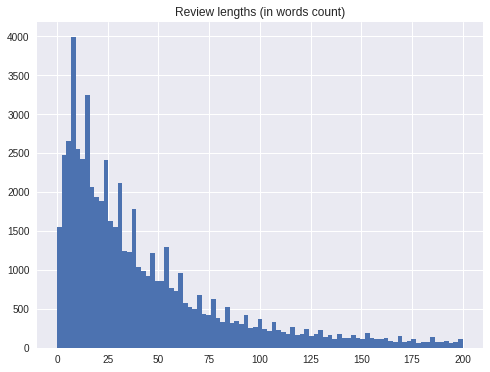

In [9]:
plt.figure(figsize=(8,6))
plt.hist(review_lengths, bins='auto', range=[0, 200])
plt.title("Review lengths (in words count)")
plt.show()

### Processing
Simple Text tokenization and cleaning

In [0]:
char1_re = re.compile('"')
char2_re = re.compile('،')
char3_re = re.compile('\.')
char4_re = re.compile('!')
char5_re = re.compile('؟')
char6_re = re.compile('؛')
char7_re = re.compile('-')
char8_re = re.compile('\(')
char9_re = re.compile('\)')

def cleanup(text):
    text = char1_re.sub(' " ', text)
    text = char2_re.sub(' ، ', text)
    text = char3_re.sub(' . ', text)
    text = char4_re.sub(' ! ', text)
    text = char5_re.sub(' ؟ ', text)
    text = char6_re.sub(' ؛ ', text)
    text = char7_re.sub(' - ', text)
    text = char8_re.sub(' ( ', text)
    text = char9_re.sub(' ) ', text)
    return text

add special tokens

In [0]:
BOS = '_BOS_' # Begining of sentence token
EOS = '_EOS_' # Ending of sentence token
PAD = '_PAD_' # Padding token
UNK = '_UNK_' # Unknown tokens (for unknown and low frequency words)

In [12]:
all_text = f' '.join([f'{BOS} {review} {EOS}' for review in tqdm(df['review'].tolist())])

100%|██████████| 63257/63257 [00:00<00:00, 748476.18it/s]


In [13]:
cleanup(all_text[:1_000])

'_BOS_   " عزازيل الذي صنعناه  ، الكامن في أنفسنا "  يذكرني يوسف زيدان بــ بورخس في استخدامه لحيلته الفنية ، وخداع القاريء بأن الرواية ترجمة لمخطوط قديم .  الهوامش المخترعة و اختلاق وجود مترجـِم عاد بي إلى بورخس و هوامشه و كتَّابه الوهميين .  هذه أولى قراءاتي ليوسف زيدان  ، وهو عبقري في السرد ويخلقُ جوَّا ساحرا متفرداً يغرقك في المتعة .  هُنا يتجلى الشكُّ الراقي الممزوج بانسانية هيبا الفاتنة ربما تم تناول فكرة الرواية قبلاً  ، ولكن هنا تفرداً و عذوبة لا تُقارن بنصٍ آخر كنتُ أودُّ لو صيغت النهاية بطريقة مختلفة فقد جاءت باردة لا تتناسب مع رواية خُطَّت بهذا الشغف  .  ولذا لا أستطيع منح الرواية خمس نجوم  ، وإن كانت تجربة قرائية متفردة وممتعة .   _EOS_ _BOS_  من أمتع ما قرأت من روايات بلا شك .  وحول الشك تدندن  ( عزازيل )  بلا هوادة .  أحمد الديب 2008 _EOS_ _BOS_  رواية تتخذ من التاريخ  ، جوًا لها اختار المؤلف فترة تاريخية ندر من يتناولها روائيًا .  مكتوبة بدقة وإتقان وجمال . من أروع ما يمكن أن تقرأ من الروايات التاريخية .  تركز على الإنسان . صانع المعنى ومدمره  .  _EOS_ _BOS_  إني أقدّر هذ

In [0]:
all_text = cleanup(all_text)

#### Word2Vec Parameters

In [0]:
# input parameters
occur_min   = 10    # Remove all words that does not appears at least n times
num_skips   = 2     # How many times to reuse an input to generate a label
num_sampled = 64    # Number of negative examples to sample
# model parameters
vocab_size  = 10000 # Number of different words in the vocabulary (V)
embed_size  = 200   # Dimension of the word representations (D)
skip_window = 3     # Number of words considered left and right (C)

batch_size  = 64

In [0]:
words = [w for w in all_text.split(' ') if w is not '']

#### Filter out words with low frequency to limit vocab size

In [19]:
counts = collections.defaultdict(lambda: 0)

for w in tqdm(words):
    if w is '': continue
    counts[w] = counts[w] + 1

100%|██████████| 4320183/4320183 [00:03<00:00, 1401439.23it/s]


In [20]:
counts['تجربة'], counts['رواية']

(879, 10310)

limit size of vocabulary

In [0]:
counts = dict(list(sorted(counts.items(), reverse=True, key=lambda x: x[1]))[:vocab_size])

words with lowest frequencies

In [0]:
ordered_counts = dict(sorted(counts.items(), reverse=True, key=lambda x: x[1]))

In [23]:
list(ordered_counts.items())[-10:]

[('مستهلكة', 39),
 ('أضفت', 39),
 ('للتعامل', 39),
 ('القبائل', 39),
 ('مقبرة', 39),
 ('إبن', 39),
 ('عارفين', 39),
 ('2013', 39),
 ('سلوكيات', 39),
 ('الإملائية', 39)]

In [24]:
counts[BOS]

63257

In [0]:
vocab = [w for w, c in counts.items() if c >= occur_min]
vocab_size = len(vocab)

In [26]:
vocab_size

10000

Create indices on vocabulary

In [0]:
itoa = dict((i, w) for i, w in enumerate(vocab))
atoi = dict((w, i) for i, w in enumerate(vocab))

In [28]:
atoi['تجربة'], atoi['رواية']

(461, 35)

#### Add the unknown token

In [0]:
atoi[UNK] = len(vocab)
itoa[len(vocab)] = UNK
# increment the vocab size as we've added the UNK token
vocab_size += 1

In [0]:
atoi = collections.defaultdict(lambda: len(vocab), atoi)
itoa = collections.defaultdict(lambda: UNK, itoa)

In [31]:
atoi['not found'], itoa[len(vocab) * 2]

(10000, '_UNK_')

### Training Input

#### CBOW (Continuous Bag of Word)

The CBOW architecture predicts the current word $w_{t}$ based on the context of length N $w_{t-1}, .., w_{t-N+1}, w_{t+1}, .., w_{t+N-1}$.

In [0]:
def create_cbow_data(words, skip_window):
    tot_size = len(words) - 2 * skip_window + 1
    ctx_size = 2 * skip_window
    # the list of ngrams that will be 
    X, y = np.zeros((tot_size, ctx_size)), np.zeros(tot_size)
    for t in tqdm(range(skip_window, len(words) - skip_window)):
        # context of the prediction
        prev_words = [atoi[words[t-i-1]] for i in range(skip_window)]
        next_words = [atoi[words[t+i+1]] for i in range(skip_window)]
        context = prev_words + next_words
        # current word to predict
        target = atoi[words[t]]
        # append indexes
        X[t - skip_window] = context
        y[t - skip_window] = target
    return X, y

The NGram architecture predicts the current word $w_t$ based on the previous N words $w_{t-1}, ,.. w_{t-N}$.

In [0]:
def create_ngram_data(words, skip_window):
    tot_size = len(words) - skip_window + 1
    ctx_size = skip_window
    # the list of ngrams that will be 
    X, y = np.zeros((tot_size, ctx_size)), np.zeros(tot_size)
    for t in tqdm(range(skip_window, len(words))):
        # context of the prediction
        context = [atoi[words[t-i-1]] for i in range(skip_window)]
        # current word to predict
        target = atoi[words[t]]
        # append indexes
        X[t - skip_window] = context
        y[t - skip_window] = target
    return X, y

The SkipGram architecture predicts $N$ surrounding words $w_{t-1}, .., w_{t-N}, w_{t+1}, .., w_{t+N}$    given the current word $w_t$.

In [0]:
def create_skipgram_data(words, skip_window):
    # bounding indices
    min_index = 0
    max_index = len(words)-1
    # the list of ngrams that will be 
    X, y = [], []
    # create dataset
    for t, wt in tqdm(enumerate(words)):
        # add words from the previous skip window
        for past in range(t-1, max(min_index, t-skip_window)):
            X.append(atoi[wt])
            y.append(atoi[words[past]])
        # add words from the next skip window
        for future in range(t+1, min(max_index, t+skip_window)):
            X.append(atoi[wt])
            y.append(atoi[words[future]])
    return X, y

In [34]:
X, y = create_cbow_data(words, skip_window)
X.shape, y.shape

100%|██████████| 4320177/4320177 [00:22<00:00, 194522.95it/s]


((4320178, 6), (4320178,))

split input into training and validation sets

In [0]:
split_index = int(len(X) * 0.9)

In [0]:
X_train, y_train = torch.LongTensor(X[:split_index]), torch.LongTensor(y[:split_index])

In [37]:
X_train.shape, y_train.shape

(torch.Size([3888160, 6]), torch.Size([3888160]))

In [38]:
X_train.device, y_train.device

(device(type='cpu'), device(type='cpu'))

In [0]:
#i = 0
#for win, wout in ngrams:
#    print(win, wout)
#    i += 1
#    if i==10: break

In [0]:
class SkipGramDataset(Dataset):
    """Skip Gram dataset."""

    def __init__(self, vocab, atoi, itoa, ngrams):
        """
        Args:
            vocab      (list): list of words constinuting the Vocabulary.
            atoi (dictionary): word to index Directory.
            itoa (dictionary): index to word Directory.
            ngrams     (list): list of ngrams created with a skip window (left & right) 
        """
        self.vocab = vocab
        self.atoi, self.itoa = atoi, itoa
        self.ngrams = ngrams

    def __len__(self):
        return len(self.ngrams)

    def __getitem__(self, idx):
        win, wout = ngrams[idx]
        return (self.atoi(win), self.atoi(wout))

In [0]:
#dataset = SkipGramDataset(vocab, atoi, itoa, ngrams)

## Model
Continuous Skip-gram Model in PyTorch

In [0]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embed_size, skip_window):
        super().__init__()
        self.embeds = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.lin1 = nn.Linear(in_features=embed_size * skip_window * 2, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=vocab_size)
        
    def forward(self, inputs):
        bs = inputs.shape[0]
        # X shape should be (batch_size, 1)
        out   = self.embeds(inputs)       # (batch_size, embedding_dim * skip_window)
        out   = out.view((bs, -1))
        #pdb.set_trace()
        out   = F.relu(self.lin1(out))    # (batch_size, vocab_size)
        out   = self.lin2(out)
        probs = F.log_softmax(out, dim=1) # (batch_size, vocab_size)
        return probs

In [42]:
model = CBOWModel(vocab_size, embed_size, skip_window); model

CBOWModel(
  (embeds): Embedding(10001, 200)
  (lin1): Linear(in_features=1200, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=10001, bias=True)
)

In [0]:
use_gpu = True

In [0]:
if use_gpu:
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    model = model.cuda()

In [0]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Train

In [0]:
def run(model, dataloader):
    total_loss = 0
    # for every batch in the DataLoader
    for batch in tqdm(dataloader):
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        X, y = batch
        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next words
        log_probs = model(X)
        
        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        #loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        loss = loss_function(log_probs, y)
        
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
        
    return total_loss

In [0]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [48]:
losses = []
for epoch in range(10):
    total_loss = run(model, train_dl)
    losses.append(total_loss)
# Check if the loss decreased after every iteration
print(losses)  

100%|██████████| 60753/60753 [04:28<00:00, 226.25it/s]

[367071.9159064293, 365825.2197341919, 365690.739133358, 365633.3219656944, 365630.3743991852, 365634.8452825546, 365605.0808401108, 365626.6608557701, 365582.65065193176, 365602.3902158737]


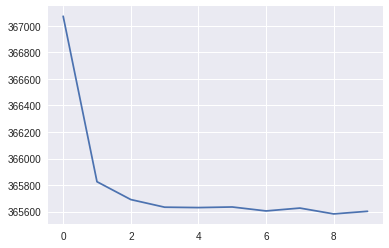

In [49]:
plt.plot(losses)

#### Save model

In [0]:
model_path = Path('/gdrive/My Drive/data/word2vec_arabic.pth')

In [0]:
#torch.save(model, model_path)

In [59]:
model1 = torch.load(model_path)
model1.eval()

CBOWModel(
  (embeds): Embedding(10001, 200)
  (lin1): Linear(in_features=1200, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=10001, bias=True)
)

### Validation

In [0]:
X_valid, y_valid = torch.LongTensor(X[split_index:]).cuda(), torch.LongTensor(y[split_index:]).cuda()

valid_ds = TensorDataset(X_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

## tSNE

In [0]:
#features = [model.embeds(torch.LongTensor(atoi[w]).cuda()) for w in words]
word_idxs = [atoi[w] for w in words]

In [63]:
model.embeds()

Embedding(10001, 200)

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(features)